# Simulating Planetary Systems with Rebound
Project Lead: Miguel A. S. Martinez

# 0. Prelude

In this mini-project, we will look at how to use one of the most important tools in the astronomy arsenal: numerical simulation. We will use the Python package Rebound (https://rebound.readthedocs.io/en/latest/) to learn about some different considerations when simulating gravitationally bound systems. However, before that, we need to understand what we're trying to simulate. 

The first person to accurately describe the motion of planets around our Sun was Johannes Kepler, who described their motions in three laws. First, watch this video produced by NASA to learn more.

https://www.youtube.com/watch?v=wjOOrr2uPuU

From this video, we see that there are two key quantities describing an orbit: semi-major axis $a$ and eccentricity $e$. But wait, what about the orbital period $T$? As in Kepler's Third Law, we know that $T^2\propto a^3$, but how do we get from units of time to units of distance? We know from Newton's laws that the gravitational force depends on the distance between two objects, the masses of both objects, and the gravitational constant $G$. So, you guess think that the formula for the orbital period must include $G$ and the two masses, as those are the two other pieces of information missing here, which is absolutely correct! The formula for the orbital period in its full glory is

$T = 2 \pi \sqrt{\frac{a^3}{GM}}$. 

Here, $M=m_1+m_2$. When $m_1 \gg m_2$, such as in the case of the Sun and the Earth, we can let $M=m_1+m_2\approx m_1$.

---
Question 1: We should check this assumption. Look up the masses of the Sun and the Earth, the distance from the Earth to the Sun, and $G$ in SI units. Calculate the orbital period of the Earth twice. The first time, let $M$ be sum of the masses of the Earth and the Sun. The second time, let $M$ be only the mass of the Sun. How different are your answers? Do you think this assumption is valid?



A: M_Earth = 3e-6 M_Sun, so this assumption is well within the uncertainty/rounding error for the mass of the sun.

So now, we know that we need a few pieces of information to specify the orbit of two bodies with respect to each other namely their masses, the semi-major axis of the orbit, and the orbital eccentricity*. However, we still have one last detail to iron out: what units are we using? It is extremely convenient in these kinds of simulation to work in units where $G=1$ (as opposed to its SI value). Then, based on this we can choose units for two of the mass, distance, and time, and use the formula above to solve for the third. In this example, we will work with masses in units of the mass of the Sun ($1\, M_\odot \approx 2 \cdot 10^{33} \,\, \rm{grams}$) and distances in astronomical units, roughly the semi-major axis of the Earth with respect to the Sun ($1\, \rm{au} = 149,597,870,700\,\,\rm{m}$ by definition)**. Using the formula above, we find

$T = 2 \pi \sqrt{\frac{(\rm{au})^3}{G\cdot M_\odot}} = 2 \pi$.

This tells us that for Earth's orbit around the Sun, in this system of units, the Earth takes $2\pi$ time units to return to its initial position. In our normal system of units, that's a year. So, since $2\pi\,\rm{unit}=1\,\rm{year}$, we know our new time unit is related to the normal year by $\frac{\rm{year}}{2\pi}$.

*Keep in mind this is only true in the simplest case. If we want to describe this orbit with respect to something else, such as a fixed background of stars or another planet much further away, we'll need a few more pieces of information about the orbit's orientation.

**I choose these units because they will be convenient for the types of systems we will be simulating. In other contexts, other choices of units might be more appropriate. 

---
Question 2: Say that instead of using these new time units and $G=1$, we wanted to just use years. Using the above formula and assuming we keep the other units (solar masses, astronomical units), find what the numerical value of $G$ should be for an orbit of 1 au and total mass 1 $M_\odot$ with orbital period 1 year.

---


A: 4*pi^2

So now that we have all the information we need, let me explain a little what we're doing here. If you've taken any sort of physics class, you probably have made gratuitous use of the following equations:

$\overrightarrow{F}=m\overrightarrow{a}$

$\overrightarrow{v}=\overrightarrow{v}_0+\overrightarrow{a}t$

$\overrightarrow{x}=\overrightarrow{x}_0+\overrightarrow{v}t$

In the beginning of our simulation, we'll have the initial positions and velocities of the particles in our simulation. Using Newton's Second Law and Newton's Law of Gravitation, we can calculate the acceleration on each particle individually. Then, using the acceleration and velocity at one time, we can find the new velocities and positions of all particles after a time $t$. The key point here is that the velocity of the particles will constantly be changing direction and magnitude, so we need to use a combination of short timesteps and clever algorithms to make sure everything goes well. Details about how this is implemented are out of the scope of this project, but you should know that this process is known as *numerically integrating the equations of motion* and the algorithm used to do this is called an *integrator*.

Now that all of those details are out of the way, let's install and import the necessary modules and get our hands dirty

In [ ]:
%pip install rebound

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255 kB 5.1 MB/s 
  Created wheel for rebound: filename=rebound-3.19.3-cp37-cp37m-linux_x86_64.whl size=604099 sha256=af1045e0f97c153590401e083d605954bbaeca913ce4995d0afa48d96e23c2bd
  Stored in directory: /root/.cache/pip/wheels/b7/ad/4e/17f873dfcb15eeed866dba5f71b77ecb539b140abb6bd7eabf
Successfully built rebound


You can choose to do this project on your local machine, but if you use Windows, you'll need to use the Windows Subsystem for Linux. This package cannot be installed on Windows. I suggest either way to do this project on colab.

In [ ]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# 1. Making Sure Everything Works

Besides Rebound, we've also imported numpy for some convenience functions and pyplot for plotting results.

In order to simulate with Rebound, we must first create a Simulation instance.

In [ ]:
sim = rebound.Simulation()

Next, we need to set the value of $G$ before doing anything else. I will use the value of $G$ from Question 2 for convenience.

In [ ]:
sim.G = 4*np.pi**2

Having created our simulation and set the value of $G$, we can now add particles to the simulation using sim.add(). The two particles we want are the Sun and the Earth. Since we're working in solar masses, the mass of the Sun is 1 by definition. We can add a particle with m=1. With no other arguments, this particle will default to the origin of the coordinate system (0,0,0).

In [ ]:
sim.add(m=1) # The Sun

For the Earth, we know a=1. How about the mass? You found earlier as part of Question 1 that we can effectively ignore the mass of the Earth when calculating the orbital period. Here, we will do something similar by treating the Earth as a "test particle" with zero mass. As a result, the Earth particle will feel the Sun's gravity but the Sun won't feel the Earth's gravity.

Even though the Earth's orbit is slightly eccentric, let's set e=0 for now and mess around with it later.

In [ ]:
sim.add(a=1,e=0) # The Earth

We've added our two particles, but we still need to add a few more lines of code before we can begin. 

In [ ]:
sim.integrator = "whfast" # choice of integrator
sim.dt = 1e-2 # timestep size
sim.move_to_com() # change coordinate system origin to the center of mass

Now, we're ready to simulate! But before we do that, let's check on the status of our simulation.

In [ ]:
sim.status()

---------------------------------
REBOUND version:     	3.19.3
REBOUND built on:    	Jun 16 2022 16:31:55
Number of particles: 	2
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.010000
---------------------------------
<rebound.particle.Particle object at 0x7fa97b444440, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.particle.Particle object at 0x7fa97b444560, m=0.0 x=1.0 y=0.0 z=0.0 vx=0.0 vy=6.283185307179586 vz=0.0>
---------------------------------


As you can see, Rebound converted the semi-major axis and eccentricity we supplied to positions and velocities. We have $x=1$ and $v_y=2\pi$ exactly, with the other coordinates set to 0. Let's see what happens to the position of the planet after we integrate the system for an orbital period.

In [ ]:
sim.integrate(1)
sim.status()

---------------------------------
REBOUND version:     	3.19.3
REBOUND built on:    	Jun 16 2022 16:31:55
Number of particles: 	2
Selected integrator: 	whfast
Simulation time:     	1.0000000000000000e+00
Current timestep:    	0.010000
---------------------------------
<rebound.particle.Particle object at 0x7fa97b4448c0, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.particle.Particle object at 0x7fa97b444b00, m=0.0 x=0.9999999999999987 y=-1.3877787807814457e-17 z=0.0 vx=-4.246603069191224e-15 vy=6.283185307179591 vz=0.0>
---------------------------------


Now, we can see that, unlike before, $x$ is only close to 1, not exactly 1. Same with $v_y$. They're ever so slightly different from their original values. Same with $y$ and $v_x$; they're not exactly 0 anymore, but they're so small that they might as well be 0 for all intents and purposes. These slight differences can arise from two different sources. The first is due to [floating-point error](https://www.geeksforgeeks.org/floating-point-error-in-python/), which I'm pretty sure is the cause of the discrepancy here. The second can arise from our choices of timestep and integrator, which we will discuss later.

---

Question 3. Now, in the space below, change the value of the variable to another integer greater than 1 to integrate to that time. Do this for a couple different values (e.g., 3, 10, 30, or whatever you want). Does the difference between initial position and final position seem to increase as you increase the amount of time?

In [ ]:
your_number_here = 3
sim.integrate(your_number_here)
sim.status()

---------------------------------
REBOUND version:     	3.19.3
REBOUND built on:    	Jun 16 2022 16:31:55
Number of particles: 	2
Selected integrator: 	whfast
Simulation time:     	3.0000000000000000e+00
Current timestep:    	0.010000
---------------------------------
<rebound.particle.Particle object at 0x7fa97b720560, m=1.0 x=0.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=0.0>
<rebound.particle.Particle object at 0x7fa97f7f3a70, m=0.0 x=0.9999999999999973 y=3.0703141784071577e-13 z=0.0 vx=-1.9268433915168672e-12 vy=6.283185307179597 vz=0.0>
---------------------------------


---
Question 4. (optional) You might have noticed that no matter when you integrate to in the previous part (even if it's not an integer!) both the z position and the z velocity both stay exactly 0. What this means is that the planet has been confined to the x-y plane. Can you think of a physical principle that would require this to be the case?

Hint: Conservation of ***angular momentum***

If you can't think of it, the answer will be mentioned in the text shortly.

---

We've shown that at simulating the Earth's orbit in this way confirms one expected behavior: after one orbital period, the planet returns to its initial position. However, we can do a lot better than entering random numbers.

For one, we know a priori that the orbit should look circular, so we should probably make sure that's the case. For that, we'll need to integrate the particle several times in intervals smaller than the orbital period and get the position of the planet.

While we're at it, we might as well get some other information too. Two of the most important conservation laws in all of classical physics are conservation of energy and conservation of angular momentum. Calculating these two quantities is relatively simple in our case of two particles, but it can quickly become tedious and unwieldy to do by hand with larger numbers of particles. Luckily, these sorts of codes always come with function that do this for us! Unluckily, these functions don't work for test particles with no mass, so I'll need to write a function for you.

So now, I'll initialize and set up a new simulation just like before.

In [ ]:
def E_tot(x, y, vx, vy, G=4*np.pi**2):
  '''
  This function calculates the specific total energy of a test particle 
  around a central mass of M=1 confined to the x-y plane
  '''
  return -1*(0.5*(vx*vx + vy*vy) - G/np.sqrt(x*x + y*y))

def L_tot(x, y, vx, vy):
  '''
  This function calculates the specific angular momentum of a test particle 
  around a central mass confined to the x-y plane
  '''
  return x*vy - y*vx

In [ ]:
# initialize simulation and choose options
sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.integrator = "whfast"
sim.dt = 1e-3

# add particles
sim.add(m=1) # Sun
sim.add(a=1) # Earth

# change to center of mass frame
sim.move_to_com()

So far, so good. Next, I will define all the relevant variables needed to get the information we need. Since the orbit is confined to the x-y plane, the angular momentum vector is always confined to the z direction.

In [ ]:
nperiods = 10 # we'll integrate for 10 orbital periods total
times = np.linspace(0,nperiods,num=10*nperiods+1) # this is so that each output occurs at exactly multiples of 0.1

# preallocate the arrays that will contain particle data
xs, ys = np.zeros(len(times)), np.zeros(len(times)) # particle position
vxs, vys = np.zeros(len(times)), np.zeros(len(times)) # particle velocities

Now, we're almost done. In the cell below, I've set up most of the for-loop required to get all the information required. However, I've left out the lines required to get the particle x and y coordinates and velocities.

---

Question 5. Take a look at the second code box in the [documentation](https://rebound.readthedocs.io/en/latest/particles/) to see how to access a particle's x and y coordinates and velocities. After the loop finishes, use the positions and velocities to calculate energy and angular momentum. Note: Since Python counting starts from 0, the index for the particle we're interested in is 1. Fill in the rest of those lines and run the cell.

In [ ]:
for i in range(len(times)):
    sim.integrate(times[i])
    vxs[i] = sim.particles[1].vx
    vys[i] = sim.particles[1].vy
    xs[i] = sim.particles[1].x
    ys[i] = sim.particles[1].y

print(xs)

# calculate energy and angular momentum here
Es = E_tot(xs,ys,vxs,vys)
Ls = L_tot(xs,ys,vxs,vys)

[ 1.          0.80901699  0.30901699 -0.30901699 -0.80901699 -1.
 -0.80901699 -0.30901699  0.30901699  0.80901699  1.          0.80901699
  0.30901699 -0.30901699 -0.80901699 -1.         -0.80901699 -0.30901699
  0.30901699  0.80901699  1.          0.80901699  0.30901699 -0.30901699
 -0.80901699 -1.         -0.80901699 -0.30901699  0.30901699  0.80901699
  1.          0.80901699  0.30901699 -0.30901699 -0.80901699 -1.
 -0.80901699 -0.30901699  0.30901699  0.80901699  1.          0.80901699
  0.30901699 -0.30901699 -0.80901699 -1.         -0.80901699 -0.30901699
  0.30901699  0.80901699  1.          0.80901699  0.30901699 -0.30901699
 -0.80901699 -1.         -0.80901699 -0.30901699  0.30901699  0.80901699
  1.          0.80901699  0.30901699 -0.30901699 -0.80901699 -1.
 -0.80901699 -0.30901699  0.30901699  0.80901699  1.          0.80901699
  0.30901699 -0.30901699 -0.80901699 -1.         -0.80901699 -0.30901699
  0.30901699  0.80901699  1.          0.80901699  0.30901699 -0.30901699
 -

Great! But we're not done yet. We still need to graph the data!

---

Question 6. In the cell below, use matplotlib to make three separate figures:

a) Use plt.scatter() to graph the x-y positions of the particle over time. Use matplotlib to draw a circle with radius 1 centered at the origin. Do the particle positions trace out the circumference of the circle? Note: You will probably want to draw the circle *first* and then the scatterplot second. Bonus challenge: Add a color bar so that the points illustrate time evolution.

b) Use plt.plot() to show the absolute fractional error evolution of both the energy and angular momentum over time. That is, for energy,

$ |\Delta E| = | (E_t - E_0)/E_0 | $

where the t subscript represents the energy at some time and the 0 subscript represents the initial energy. Note: you'll probably want to use logarithmic axes for these two plots.

Bonus challenge: Rerun the previous three cells but change the eccentricity of the Earth to be a value between 0 and 1. Repeat part (a) of Question 6, but instead use matplotlib to plot an ellipse under your data points. You'll need to look up using Google the relationship between eccentricity and the semi-minor axis. You'll also need to change the center of the ellipse and you might have to rotate it. Don't choose a value of e too close to 1 (e.g. 0.999) because the integrator might start to have problems. 


Text(0, 0.5, 'Y pos')

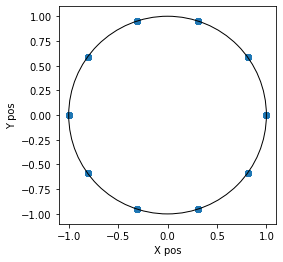

In [ ]:
fig,ax = plt.subplots()
ax.add_patch(plt.Circle((0,0),radius=1,fill=False))
ax.scatter(xs,ys)
ax.set_aspect('equal')
ax.set_xlabel('X pos')
ax.set_ylabel('Y pos')

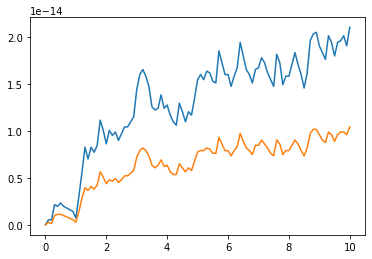

In [ ]:
plt.plot(times,(np.abs(Es-Es[0])/Es[0]))
plt.plot(times,(np.abs(Ls-Ls[0])/Ls[0]))

Now hopefully, everything looks good. We should have gotten a circle and the energy and angular momentum changes should be negligible. 

Next up, we want to try to understand the limits of the method we're using. In other words, let's break the code. I mentioned in the bonus challenge above that choosing an extreme value of eccentricity might break something. The reason for this is that, as a consequence of Kepler's second law, when eccentricity is very large, the particle's velocity as it passes through perihelion can be very fast. If the timestep is too small, then it will not properly resolve the perihelion passage.


---

Question 7. In this problem, we want to study the effect of varying both the eccentricity and the timestep. Write a python function in the cell below that does the same simulation as before, except varying the eccentricity of the particle and the timestep used by the simulation. 

* Your function will have two inputs. First, $dt$, the timestep. Second, $1-e$. We want to use $1-e$ because it's a better diagnostic of how closely the particle will approach the star since the distance of closest approach $r=a(1-e)$. Remember to convert $1-e$ to $e$ when adding the particle. 

* Your function should integrate the system until $t=100$, or 100 orbital periods.

* Your function should output the fractional energy and angular momentum errors

Once your function is complete, run your function for values of $1-e$ between 1e-6 and 1e-1. You can choose how many data points to do this for, but if you do too many you'll have to wait a while for the code to run! Repeat this for $dt=$1e-4,1e-3,1e-2,1e-1,1. Plot your results using a logarithmic axis.

Write down your observations. How does the error change as you increase the eccentricity and timestep size?

In [ ]:
def myfunc(dt=1e-3, eps=1):
    # your code here
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.integrator = "whfast"
    sim.dt = dt

    sim.add(m=1)
    sim.add(a=1,e=1-eps)

    sim.move_to_com()
    E0 = E_tot(sim.particles[1].x,sim.particles[1].y,sim.particles[1].vx,sim.particles[1].vy)
    L0 = L_tot(sim.particles[1].x,sim.particles[1].y,sim.particles[1].vx,sim.particles[1].vy)

    sim.integrate(100)
    E1 = E_tot(sim.particles[1].x,sim.particles[1].y,sim.particles[1].vx,sim.particles[1].vy)
    L1 = L_tot(sim.particles[1].x,sim.particles[1].y,sim.particles[1].vx,sim.particles[1].vy)

    dE = np.abs(E1-E0)/E0
    dL = np.abs(L1-L0)/L0
    return dE, dL


In [ ]:
# run your function here
eps_list = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
e_errs = np.array([myfunc(eps=eps) for eps in eps_list])

t_list = [1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1,1]
t_errs = np.array([myfunc(dt=t) for t in t_list])

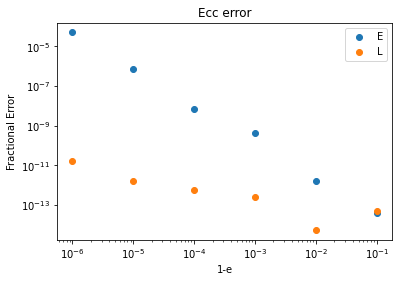

In [ ]:
# plot your results here
plt.scatter(eps_list,e_errs[:,0],label='E')
plt.scatter(eps_list,e_errs[:,1],label='L')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('1-e')
plt.ylabel('Fractional Error')
plt.title('Ecc error')
plt.legend()

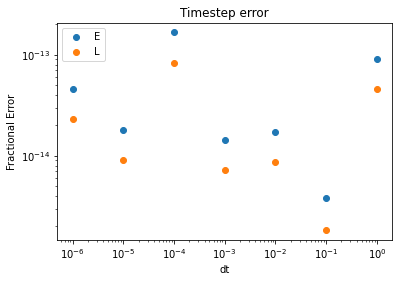

In [ ]:
plt.scatter(t_list,t_errs[:,0],label='E')
plt.scatter(t_list,t_errs[:,1],label='L')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('dt')
plt.ylabel('Fractional Error')
plt.title('Timestep error')
plt.legend()

The previous exercise hinted at a fundamental reason why there are so many different kinds of codes to do different things. All codes are written to work well under specific conditions. If these conditions are broken, then the results may be complete nonsense. A one size fits all approach to the problem of gravity may be too slow or computationally intensive. In this case, the algorithm we're using, WHFast, is optimized for studies of systems similar to the Solar System, where there are many planets but their orbits stay roughly constant for all time and there are no close encounters. For this reason, Rebound comes with several integrators. One of them, IAS15 is meant to be as general as possible and does not rely on near-constant orbits. Instead of adopting a smaller timestep to achieve precision, the integrator uses adaptive timestepping. When velocities are large, timesteps are small. When velocities are small, timesteps are large. The main downside, among others, is that this may result in very long integrations. But, so does using very small timesteps.

---

Question 8. Modify the previous function (copy it to the cell below and then modify it, name included) to use "ias15" instead of "whfast". Remove the line that defines the timestep. This function will have the same output as before, but it will have only one input, $1-e$. Run this function for the same values of $1-e$ above and compare your results by replotting the previous data with the new data.

In [ ]:
def newfunc(eps=1):
    # your code here
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.integrator = "ias15"

    sim.add(m=1)
    sim.add(a=1,e=1-eps)

    sim.move_to_com()
    E0 = E_tot(sim.particles[1].x,sim.particles[1].y,sim.particles[1].vx,sim.particles[1].vy)
    L0 = L_tot(sim.particles[1].x,sim.particles[1].y,sim.particles[1].vx,sim.particles[1].vy)

    sim.integrate(100)
    E1 = E_tot(sim.particles[1].x,sim.particles[1].y,sim.particles[1].vx,sim.particles[1].vy)
    L1 = L_tot(sim.particles[1].x,sim.particles[1].y,sim.particles[1].vx,sim.particles[1].vy)

    dE = np.abs(E1-E0)/E0
    dL = np.abs(L1-L0)/L0
    return dE, dL

In [ ]:
# run your function here
eps_list = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
e_errs = np.array([newfunc(eps=eps) for eps in eps_list])

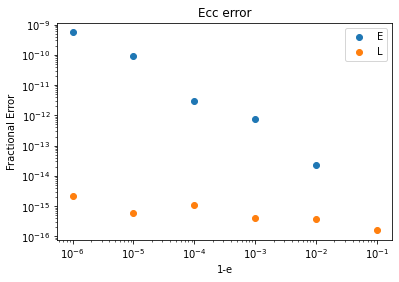

In [ ]:
# plot your results here
plt.scatter(eps_list,e_errs[:,0],label='E')
plt.scatter(eps_list,e_errs[:,1],label='L')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('1-e')
plt.ylabel('Fractional Error')
plt.title('Ecc error')
plt.legend()

# 2. Final Problem: The Hill Problem

Now that we've gone through all of that, let's work on an actual problem.

Imagine a star-planet-moon system. For simplicity, let's use the actual Sun-Earth-Moon system. Right now, the orbit of the Moon around the Earth is stable. However, due to tidal forces, the moon is being pushed into orbits further away over extremely long timescales. At some point, one can imagine that this may drive the moon into a semimajor axis which is unstable due to influence of the Sun. Let's try to figure out where that boundary is.

Part 1. Write a function like the ones previous. This time, you'll add a third particle, the moon.

* The moon will be a test particle, so you can set the mass `m=0`. The Earth's mass in solar masses is about `m=3e-6`.

* This time, the Moon will be orbiting the Earth, so you need to add the moon so that the reference body is the Earth. For this, you will need to learn how to set the primary. See the example below I copied from the documentation [here](https://rebound.readthedocs.io/en/latest/ipython_examples/OrbitalElements), specifically the section titled "Reference Bodies." The semimajor axis of the Moon around the Earth is `a=0.00257` in AU and for the Earth around the Sun `a=1` by definition.
```
# to add a planet around a reference body
sim.add(primary=sim.particles[1],a=0.00257)
```

* This function will have one output: the semi-major axis of the Moon around Earth. Again, see the example below from the documentation linked above.
```
# to calculate the semimajor axis around a reference body
sim.particles[2].calculate_orbit(primary=sim.particles[1]).a
```

* The function should integrate the system for 100 years. You can choose either whfast with `dt=1e-3` or ias15 as your integrator. 

* This function will only need one output: the final Moon semi-major axis with respect to the Earth. Since we only care about the end result, you don't need to code a for loop. 

Part 3. Run your function for a bunch of different values. Plot initial Moon semi-major axis on the x-axis and final Moon semi-major axis on the y-axis. 

* The minimum should be the Moon's current semimajor axis around the Earth. The maximum should be ten times this value. It would be helpful if your plot showed the distances in units of current Moon semimajor axis.

* Note: some of the final semimajor axes might be negative. This is fine. It just means the Moon has become unbound from the Earth.

* We want to find the crossover into region where either a) the semimajor axis of the moon changes significantly (e.g., more than 10%) or b) the moon becomes completely unbound. After running your function and producing your initial plot, you might consider choosing different minimum and maximum values so that you "zoom in" on a region of interest to get a more precise answer.

* In summary, at the end of this exercise you want to report a single number: the largest semimajor axis the Moon can have so that its orbit remains stable around the Earth.


In [ ]:
# your function here
def hill(sma=1):
    # your code here
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.integrator = "ias15"

    sim.add(m=1)
    sim.add(a=1,m=3e-6)
    sim.add(primary=sim.particles[1],a=0.00257*sma)

    sim.move_to_com()

    sim.integrate(100)
    
    a_fin = sim.particles[2].calculate_orbit(primary=sim.particles[1]).a

    return a_fin

In [ ]:
# run your function here
a_fin = np.array([hill(sma=a) for a in np.linspace(1,10,num=51)])/0.00257

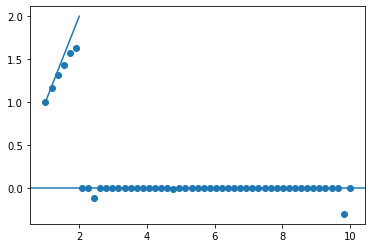

In [ ]:
# plot your data here
plt.scatter(np.linspace(1,10,num=51), a_fin)
plt.axhline()
plt.plot((1,2),(1,2))
#plt.yscale('symlog')

A: If the SMA of the moon were about twice its current value, the orbit would be unstable. This is about half the Hill radius. This is in agreement with the literature (Domingos et al 2006).

# Bonus Challenge (if there's time)

Now that you've done that, you can add one more variable to the mix. We can start varying the eccentricity!

* Add a second input to the function: the Earth's eccentricity around the Sun.

Plot your results for a few values of eccentricity (e.g., 0.1, 0.3, 0.6, 0.9).

In [ ]:
# your function here
def hill_ecc(sma=1,ecc=0):
    # your code here
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.integrator = "ias15"

    sim.add(m=1)
    sim.add(a=1,m=3e-6,e=ecc)
    sim.add(primary=sim.particles[1],a=0.00257*sma)

    sim.move_to_com()

    sim.integrate(100)
    
    a_fin = sim.particles[2].calculate_orbit(primary=sim.particles[1]).a

    return a_fin

In [ ]:
# run your function here
smas = np.linspace(1,5,num=21)
eccs = np.linspace(0,0.9,num=9)

xx,yy = np.meshgrid(smas,eccs)
positions = np.vstack([xx.ravel(), yy.ravel()])

a_fins = np.array([hill_ecc(sma=positions[0,i],ecc=positions[1,i]) for i in range(len(positions[0]))])

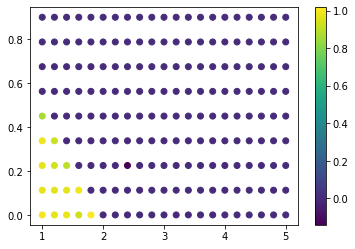

In [ ]:
# your plots here
plt.scatter(positions[0],positions[1],c=a_fins/(positions[0]*0.00257))
plt.colorbar()

A: In the previous part, we saw that the moon is about half the radius of the actual Hill sphere. Here, increasing the eccentricity to 0.5 halves the Hill radius such that the moon's orbit is no longer stable. So, we recover the (1-e) dependence.

# Spoiler

What you should see is that this boundary should be of order the [Hill Sphere](https://en.wikipedia.org/wiki/Hill_sphere). See if you can follow the derivation presented in the text. Don't stress if you can't!

# 3. Final Thoughts

The final problem was somewhat crude, but a powerful demonstration of the kinds of questions you could answer using a numerical code like Rebound. There are a number of ways we could have improved our little experiment, but alas, you don't have all day. For example, we could have run more than one simulation at each point, sampling a different orbital phase each time. We also could have used some of Rebound's other features which were made specifically to answer questions like the one we just explored, specifically the [variational equations](https://rebound.readthedocs.io/en/latest/ipython_examples/VariationalEquations/).

There are tons of other questions in the field of planetary dynamics that we could look at. One thing we didn't do was relax our Newtonian and point particle assumptions. We assumed gravity acts instantaneously and that all the mass of the particles is concentrated in a single point. If we relax those assumptions, we need to [add additional forces besides gravity](https://reboundx.readthedocs.io/en/latest/).

If you're interested in doing more, there are a ton of worked examples in the documentation for the package. Feel free to just mess around and try things. If you have any questions, feel free to contact me. I hope you enjoyed your first foray into N-body simulations.